### Objective
This document trains Vision Transformer to classify images. Dataset used in beans data from Hugging Face hub which is a collection of healthy and unhealthy beans leaves images.

In [ ]:
from datasets import load_dataset

#### Load the dataset

In [ ]:
# load the beans dataset which consists of healthy and unhealthy leaves of beans plant
data = load_dataset('beans')
data

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [ ]:
# visualize 200th example from the dataset
sample = data['train'][200]
sample

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/angular_leaf_spot/angular_leaf_spot_train.279.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 0}

In [ ]:
image = sample['image']

In [ ]:
# get all values of class label names
labels = data['train'].features['labels']
print(labels)
sample_img_label = sample['labels']

# get the label name of the sample image using int2str() function of `ClassLabel`
print(labels.int2str(sample_img_label))

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'])
angular_leaf_spot


#### Load ViT Feature Extractor
Preprocess the inpiut images into a format suitable for a ViT model. This includes:
1. Resizing
2. Normalizing pixel values
3. Converting image into a sequence of patches

In [ ]:
from transformers import ViTFeatureExtractor

In [ ]:
# use feature extractor of the model trained in ImageNet-21k (https://huggingface.co/google/vit-base-patch16-224-in21k)
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
feature_extractor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
# process the sample image using feature extractor
# returns a dict with pixel values by default
preprocessed_sample_img = feature_extractor(image, return_tensors='pt')
preprocessed_sample_img

{'pixel_values': tensor([[[[-0.6863, -0.5922, -0.5843,  ..., -0.5216, -0.5216, -0.5216],
          [-0.7333, -0.6314, -0.6314,  ..., -0.5294, -0.5059, -0.5216],
          [-0.7569, -0.6627, -0.6549,  ..., -0.5686, -0.5765, -0.5686],
          ...,
          [-0.6549, -0.6941, -0.6471,  ..., -0.7412, -0.7490, -0.7569],
          [-0.5059, -0.5373, -0.6078,  ..., -0.7333, -0.7412, -0.7569],
          [-0.5608, -0.5608, -0.5765,  ..., -0.7255, -0.7412, -0.7569]],

         [[-0.0902,  0.0196,  0.0667,  ..., -0.5451, -0.5294, -0.5216],
          [-0.1451, -0.0275, -0.0039,  ..., -0.5451, -0.5137, -0.5216],
          [-0.1529, -0.0667, -0.0510,  ..., -0.5686, -0.5686, -0.5686],
          ...,
          [-0.3020, -0.4196, -0.3176,  ..., -0.2078, -0.2235, -0.2314],
          [-0.0196, -0.0824, -0.1373,  ..., -0.2000, -0.2078, -0.2235],
          [-0.0353, -0.0275, -0.0353,  ..., -0.2000, -0.2078, -0.2157]],

         [[-0.3882, -0.2863, -0.3176,  ..., -0.6314, -0.6235, -0.6000],
          [-0

In [ ]:
# preprocess the dataset
def preprocess_data(example_batch):
  # pass a list of PIL images to feature extractor and convert them to pixel values
  inputs = feature_extractor([each_image for each_image in example_batch['image']], return_tensors='pt')

  # include labels
  inputs['labels'] = example_batch['labels']

  return inputs

# apply the transformation to the dataset to create a new dataset preprocessed_data.
# this transformation is applied 'on the fly' or lazily, meaning the preprocess_data function
# is executed only when an individual item or a batch of items is accessed from preprocessed_data.
# this is an efficient way to handle large datasets as it avoids immediately processing
# the entire dataset, saving memory and computation until needed
preprocessed_data = data.with_transform(preprocess_data)


In [ ]:
# return pixel values and label of a sample image after applying transformation
preprocessed_data['train'][200]

{'pixel_values': tensor([[[-0.6863, -0.5922, -0.5843,  ..., -0.5216, -0.5216, -0.5216],
          [-0.7333, -0.6314, -0.6314,  ..., -0.5294, -0.5059, -0.5216],
          [-0.7569, -0.6627, -0.6549,  ..., -0.5686, -0.5765, -0.5686],
          ...,
          [-0.6549, -0.6941, -0.6471,  ..., -0.7412, -0.7490, -0.7569],
          [-0.5059, -0.5373, -0.6078,  ..., -0.7333, -0.7412, -0.7569],
          [-0.5608, -0.5608, -0.5765,  ..., -0.7255, -0.7412, -0.7569]],
 
         [[-0.0902,  0.0196,  0.0667,  ..., -0.5451, -0.5294, -0.5216],
          [-0.1451, -0.0275, -0.0039,  ..., -0.5451, -0.5137, -0.5216],
          [-0.1529, -0.0667, -0.0510,  ..., -0.5686, -0.5686, -0.5686],
          ...,
          [-0.3020, -0.4196, -0.3176,  ..., -0.2078, -0.2235, -0.2314],
          [-0.0196, -0.0824, -0.1373,  ..., -0.2000, -0.2078, -0.2235],
          [-0.0353, -0.0275, -0.0353,  ..., -0.2000, -0.2078, -0.2157]],
 
         [[-0.3882, -0.2863, -0.3176,  ..., -0.6314, -0.6235, -0.6000],
          [-

In [ ]:
import torch
# collate the data
# take the list of dicts of individual data samples and combine them into a
# single batch to be fed into the model
def collate(batch):
  return {
    # gather all the pixel_values from each individual sample in the batch list
    # and stack them into a single torch.Tensor. This creates a batch of image
    # tensors, where the first dimension corresponds to the batch size
    'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
    # collect all the labels from each sample and convert them into a single torch.Tensor of labels
    'labels': torch.tensor([x['labels'] for x in batch])
  }


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


#### Define Evaluation Metrics

In [ ]:
import numpy as np
import evaluate

# load metrics from Hugging Face `evaluate` library
accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

def compute_metrics(p):
  # convert raw scores (logits) into predicted class id and find the index of the highest score using np.argmax
  preds = np.argmax(p.predictions, axis=1)
  # ground truth
  labels = p.label_ids

  return {
      # call the compute method on the accuracy metric object
      # then extract the 'accuracy' value from the dictionary returned by accuracy.compute()
      "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
      "precision": precision.compute(predictions=preds, references=labels, average='macro')["precision"],
      "recall": recall.compute(predictions=preds, references=labels, average='macro')["recall"],
      "f1_score": f1.compute(predictions=preds, references=labels, average='macro')["f1"]
  }

### Load the Pretrained Model

In [ ]:
from transformers import ViTForImageClassification
# get the labels
# by default returns ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'])
labels = data['train'].features['labels'].names
# ['angular_leaf_spot', 'bean_rust', 'healthy']
labels

# load the model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    # enumerate() iterates through the labels list, yielding both the index (i) and the value (c) for each item
    # for each pair, creates a key-value entry for the dictionary.
    # the key is the index (i) converted to a string (str(i)), and the value is the corresponding class name (c)
    # id2label dictionary would be: {'0': 'angular_leaf_spot', '1': 'bean_rust', '2': 'healthy'}
    id2label = {str(i): c for i, c in enumerate(labels)},
    # creates a key-value entry for the dictionary where key is the class name (c), and the value
    # is the corresponding index (i) converted to a string (str(i))
    # label2id dictionary would be: {'angular_leaf_spot': '0', 'bean_rust': '1', 'healthy': '2'}
    label2id = {c: str(i) for i, c in enumerate(labels)}
    )

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments
# training arguments
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = collate,
    compute_metrics = compute_metrics,
    train_dataset = preprocessed_data['train'],
    eval_dataset = preprocessed_data['validation'],
    tokenizer = feature_extractor
    )

/tmp/ipython-input-3563925175.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
training_results = trainer.train()
trainer.save_model(),
trainer.log_metrics('train', training_results.metrics)
trainer.save_metrics('train', training_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
100,0.038700,0.072240,0.977444,0.978723,0.977609,0.977604
200,0.012800,0.039938,0.992481,0.992754,0.992424,0.992506


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1161
  train_runtime            =  0:03:06.35
  train_samples_per_second =      22.195
  train_steps_per_second   =       1.395


In [ ]:
evaluation_results = trainer.evaluate(preprocessed_data['validation'])
trainer.log_metrics('evaluation', evaluation_results)
trainer.save_metrics('evaluation', evaluation_results)

***** evaluation metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_f1_score           =     0.9925
  eval_loss               =     0.0399
  eval_precision          =     0.9928
  eval_recall             =     0.9924
  eval_runtime            = 0:00:03.66
  eval_samples_per_second =     36.308
  eval_steps_per_second   =      4.641


### Prediction

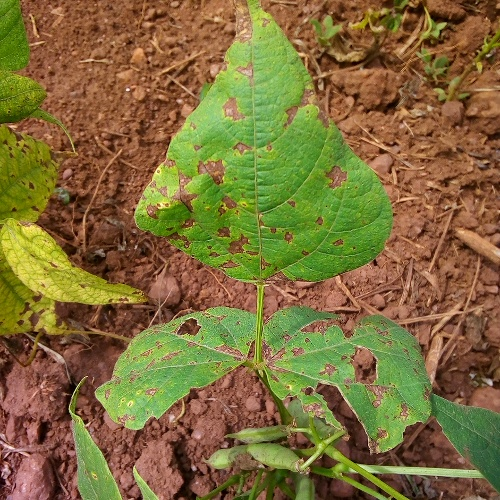

In [ ]:
test_img = data['test'][0]['image']
test_img

In [ ]:
# get the prediction
test_prediction = trainer.predict(preprocessed_data['test'].select(range(1)))
test_prediction

PredictionOutput(predictions=array([[ 3.3847656, -1.4023438, -2.0078125]], dtype=float32), label_ids=array([0]), metrics={'test_loss': 0.0128021240234375, 'test_accuracy': 1.0, 'test_precision': 1.0, 'test_recall': 1.0, 'test_f1_score': 1.0, 'test_runtime': 0.1189, 'test_samples_per_second': 8.407, 'test_steps_per_second': 8.407})

In [ ]:
from scipy.special import softmax
pred_probabilities = softmax(test_prediction.predictions)
pred_probabilities

array([[0.9872772 , 0.00823046, 0.00449234]], dtype=float32)

In [ ]:
print(labels[0], round(pred_probabilities[0][0]*100, 2), "%")
print(labels[1], round(pred_probabilities[0][1]*100, 2), "%")
print(labels[2], round(pred_probabilities[0][2]*100, 2), "%")

angular_leaf_spot 98.73 %
bean_rust 0.82 %
healthy 0.45 %


In [ ]:
print(labels)
print("Predicted class: ", labels[np.argmax(pred_probabilities)])

['angular_leaf_spot', 'bean_rust', 'healthy']
Predicted class:  angular_leaf_spot
